In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numpy.fft import fft, ifft, fftfreq
from scipy.signal import find_peaks
import pandas as pd

In [2]:
data = yf.download('DNB.OL', start='2003-01-01', end='2024-05-22')['Adj Close']
df = pd.DataFrame(data)

[*********************100%%**********************]  1 of 1 completed


In [3]:
df.rename(columns={'Adj Close': 'adj_close'}, inplace=True)

## Creating functions

In [4]:
# Define the different types of trend functions
def linear(x, a, b):
    return a * x + b

def polynomial(x, a, b):
    return a * x**2 + b

def exponential(x, a, b):
    return a * np.exp(b * x)

def logistic(x, a, b, c):
    return c / (1 + a * np.exp(-b * x))

## Setting parameters

In [5]:
data = df['adj_close'].to_numpy()
len(data)

5405

In [6]:
time

CPU times: total: 0 ns
Wall time: 0 ns


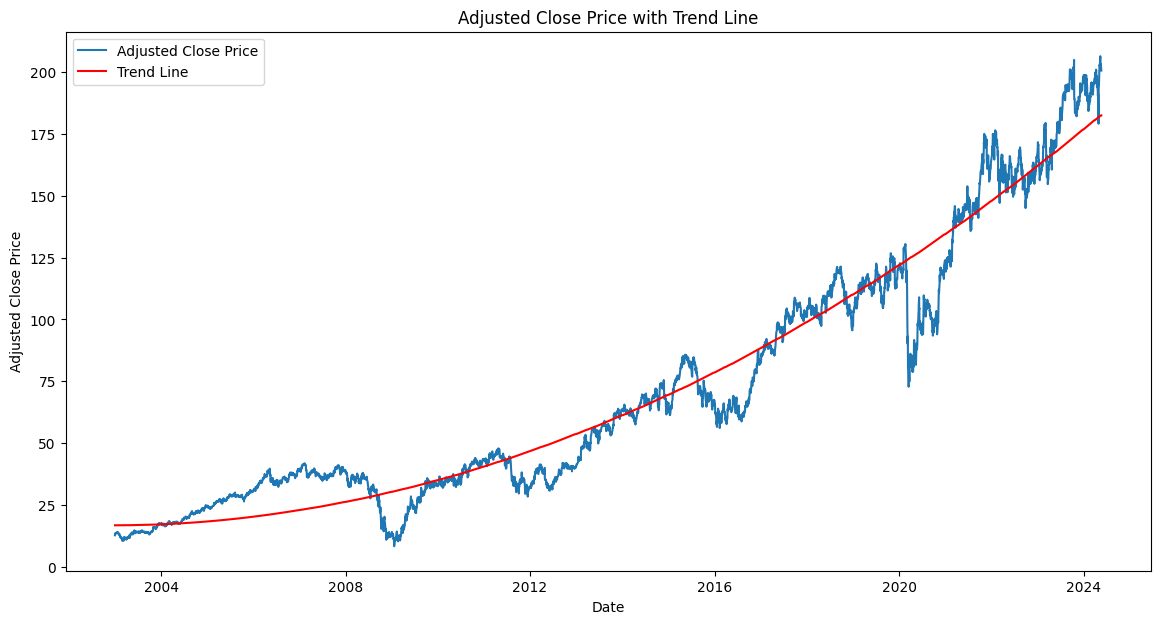

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Uavhengig variabel (tidsindeks)
time = np.arange(len(df)).reshape(-1, 1).flatten()

# initial_guess = (1, 0.01, df['adj_close'].min())

popt, _ = curve_fit(polynomial, time, data)

# Predicted trend
trend = polynomial(time, *popt)

# # Prediker trend
# trend = model.predict(time)

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['adj_close'], label='Adjusted Close Price')
plt.plot(df.index, trend, label='Trend Line', color='red')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Adjusted Close Price with Trend Line')
plt.legend()
plt.show()

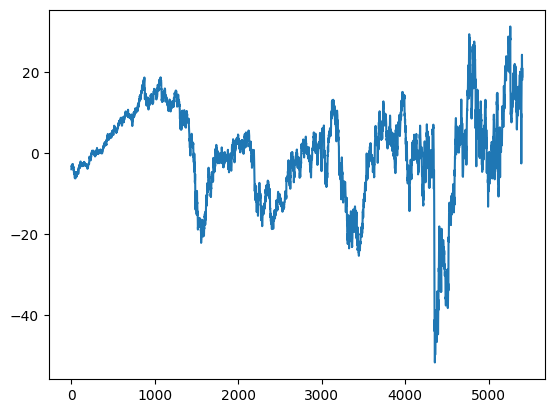

In [8]:
detrend = data - trend
plt.plot(detrend)

## Funksjoner

In [9]:
def make_sin_data(data):
    num_points = 100  # Du kan justere antallet punkter for å få ønsket glatthet i kurvene
    amplitudes = []
    phases = []
    # Gå gjennom hvert komplekse tall i X for å generere og plotte sinusfunksjonen for hver frekvens
    plt.figure(figsize=(12, 6))
    for d in data[:10]:
        amplitude = np.abs(d)  # Amplituden er størrelsen til det komplekse tallet
        amplitudes.append(amplitude)
        phase = np.angle(d)  # Fasen er vinkelen til det komplekse tallet
        phases += phase

        # Generer x-aksen 
        t = np.linspace(0, 2*np.pi, num_points)  # Her antas det at sinusoiden er én periode

        # Beregn sinusoiden med amplituden og fasen for det gjeldende komplekse tallet
        sin_wave = amplitude * np.sin(t + phase)

        plt.plot(t, sin_wave)

    

    plt.xlabel('Tiden det tar rundt en sirkel')
    plt.ylabel('Amplituden')
    plt.title('Sinus kurver for de 10 første frekvensene')
    plt.grid(True)
    plt.show()

    return amplitudes, phases

In [10]:
def create_sin (data, n, complex_func, peak_freq):
    frekvens = peak_freq
    amplitude = np.abs(complex_func)
    fase = np.angle(complex_func)
    offset = np.mean(data)

    sinwave = amplitude * np.exp(1j * (2 * np.pi * frekvens * n + fase)) + offset

    return sinwave

In [11]:
def fit_sin(n, data, complex_func, period):
    guess_freq = 2 * np.pi / period
    guess_amplitude = np.abs(complex_func)
    guess_phase = np.angle(complex_func)
    guess_offset = np.mean(data)
    
    guess_param = [guess_freq, guess_amplitude, guess_phase, guess_offset]
    
    # Sinus function to be fitted with the parameters
    def sin_func(n, freq, amplitude, phase, offset):
        return np.sin(n * freq + phase) * amplitude + offset

    # scipy.optimize.curve_fit(f, xdata, ydata, p0=None)
    fit = curve_fit(sin_func, n, data, p0=guess_param)

    optimized_params = fit[0]
    
    # Assumes ydata = f(xdata, *params) + eps.
    fitted_sin = sin_func(n, *optimized_params)

    # # Finn indeksene til maksimalverdiene (toppene)
    # peak_indices = np.where((fitted_sin[:-2] < fitted_sin[1:-1]) & (fitted_sin[1:-1] > fitted_sin[2:]))[0]
    # peaks_x = n[peak_indices]
    # peaks_y = fitted_sin[peak_indices]

    # # Beregn perioden mellom topper (avstanden mellom de to første toppene)
    # period = peaks_x[1] - peaks_x[0]

    # Finn indekser for topper i dataene
    # peaks_indices, _ = find_peaks(fitted_sin)

    # # Hent x- og y-verdier for toppene
    # peaks_x = n[peaks_indices]
    # peaks_y = data[peaks_indices]

    # Vis perioden mellom topper
    print(f"Perioden mellom topper: {period}")

    return fitted_sin, fit#, peaks_x, peaks_y

In [12]:
def create_fourier_series(data, X_oneside, f_oneside, antall_amp):
    # Calculate amplitudes and phases
    amplitudes = np.abs(X_oneside)
    phases = np.angle(X_oneside)
    
    # Sort the amplitudes in descending order and get the indices
    sorted_indices = np.argsort(amplitudes)[::-1]
    
    # Select the top n amplitudes
    top_indices = sorted_indices[:antall_amp]
    
    # Get the corresponding frequencies, amplitudes, and phases
    top_freqs = f_oneside[top_indices]
    top_amps = amplitudes[top_indices]
    top_phases = phases[top_indices]
    
    # Calculate the mean offset of the data
    offset = np.mean(data)
    
    # Initialize the Fourier series with the offset
    fourier_series = np.full(len(data), offset, dtype=np.complex128)
    
    # Add the top n frequency components to the Fourier series
    for freq, amp, phase in zip(top_freqs, top_amps, top_phases):
        t = np.arange(len(data))
        cosine_component = amp * np.cos(2 * np.pi * freq * t + phase)
        sine_component = amp * np.sin(2 * np.pi * freq * t + phase)
        fourier_series += cosine_component + sine_component
    
    return fourier_series

### Setting parameters

In [13]:
N = len(data)
n = np.arange(N)
lin_trend = len(n)

# Sampling rate
sr = 1
T = N/sr
# Sampling interval
ts = 1/sr

# Frequncies
freq = fftfreq(N, ts)

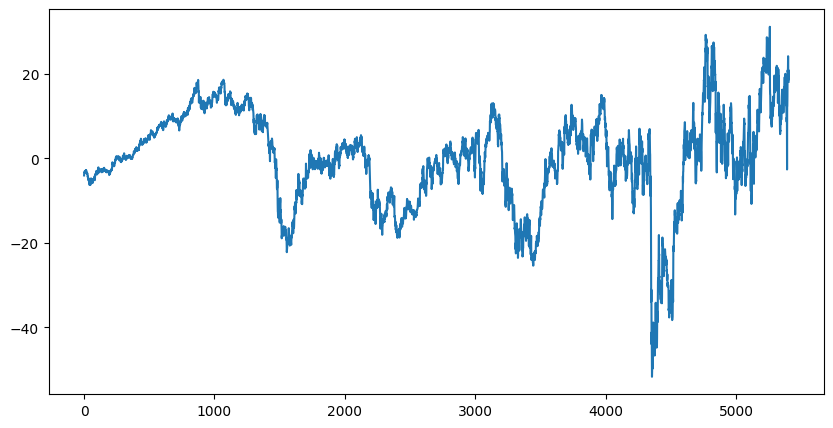

In [14]:
data_without_dc = detrend - np.mean(detrend)
plt.figure(figsize=(10, 5))
plt.plot(data_without_dc)

In [15]:
import scipy.signal

In [16]:
df['detrend'] = detrend

In [17]:
df

,adj_close,detrend
Date,,
2003-01-01,12.643925,-4.035786
2003-01-02,13.264486,-3.415230
2003-01-03,13.458410,-3.221323
2003-01-06,13.574765,-3.104997
2003-01-07,13.535982,-3.143820
...,...,...
2024-05-13,206.500000,24.191591
2024-05-14,203.600006,21.230248
2024-05-15,201.000000,18.568881


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

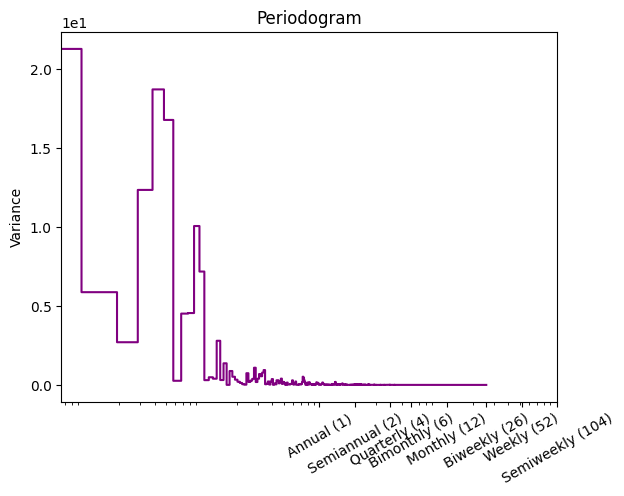

In [18]:
def plot_periodogram(ts, detrend='constant', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("52W") / pd.Timedelta("1W")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


plot_periodogram(df['detrend'])

## Ulike fourier former

Discrete fourier transform

Fast fourier transform

## Frekvensanalysen

In [19]:
ft = fft(data_without_dc)
ft[0]=0
ft

array([    0.           +0.j        , 14707.04465259-9714.36073086j,
          36.36234998-9259.79026157j, ..., -1186.60429005-6169.15794217j,
          36.36234998+9259.79026157j, 14707.04465259+9714.36073086j])

- N//2: It slices the freq array to get the one-sided frequency values, f_oneside, which range from 0 to the Nyquist frequency, which is half of the sampling frequency.

- It slices the X array to get the one-sided DFT coefficients, X_oneside, and normalizes them by dividing by n_oneside. This is to get the correct amplitude values of the signal in the time domain.

C:\Users\bugat\AppData\Local\Temp\ipykernel_7928\55991189.py:6: RuntimeWarning: divide by zero encountered in divide
  f_d = 1/f_oneside / (sr)


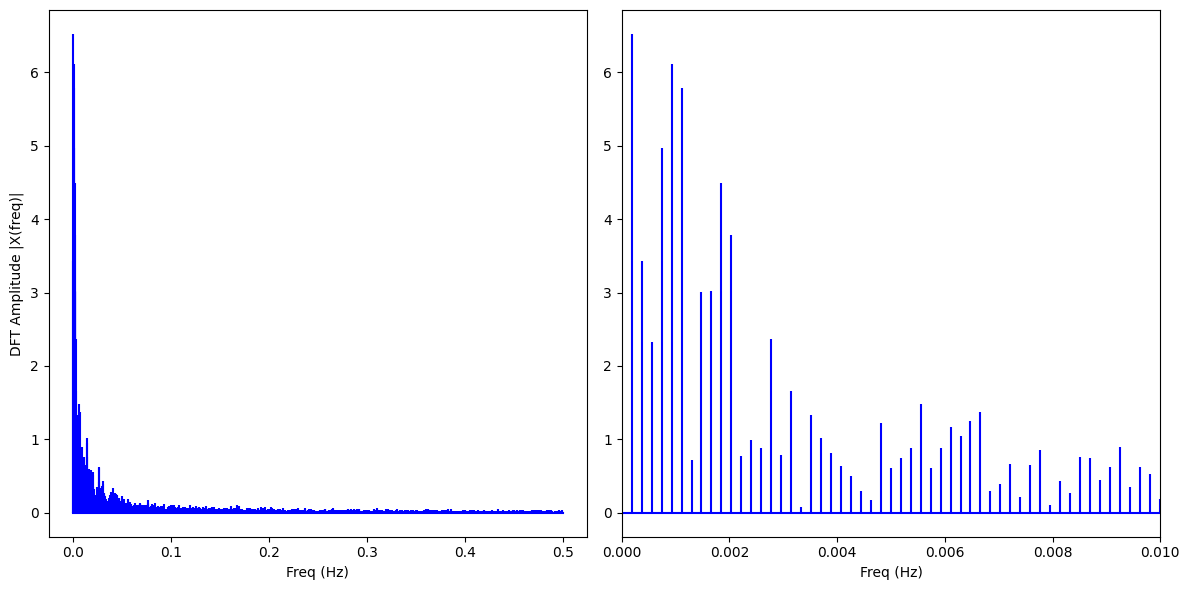

In [20]:
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

# convert frequency to days
f_d = 1/f_oneside / (sr)

# normalize the amplitude
X_oneside = ft[:n_oneside]/n_oneside

# Finding the amplitudes
amplitudes = np.abs(X_oneside)

# Finding the phases
phases = np.angle(X_oneside)

plt.figure(figsize = (12, 6))

plt.subplot(121)
plt.stem(f_oneside, amplitudes, 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')

plt.subplot(122)
plt.stem(f_oneside, amplitudes, 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.xlim(0, 0.01)
plt.tight_layout()
plt.show()

In [21]:
max_amp = np.max(amplitudes)
max_amp

6.523212028972759

In [22]:
# Calculate the absolute values of the DFT coefficients to determine the dominant frequencies within the data
max_amplitude_index = np.argmax(amplitudes)

# We find the frequency that matches the maximum amplitude in our time series
peak_freq = f_oneside[max_amplitude_index]

# Finding the max amplitude corresponding to index
max_amplitude = amplitudes[max_amplitude_index]

# Calulating the estimated period of the signal by taking the inverse of the peak frequncy
period = 1 / peak_freq
complex_func = X_oneside[max_amplitude_index]

print('Complex number: ', complex_func)
print('Index of the max ampltiude: ', max_amplitude_index)
print("Corresponding maximum amplitude: ", max_amplitude)
print("Peak frequenzy in Hz:", peak_freq)
print('Period: ', (period))

Complex number:  (5.443021707100575-3.595248234957753j)
Index of the max ampltiude:  1
Corresponding maximum amplitude:  6.523212028972759
Peak frequenzy in Hz: 0.00018501387604070305
Period:  5405.0


Peak amplitude er lik index 2, som vil si frekvens lik 2

## Sinustilpasning uten minste kvadratsmetode

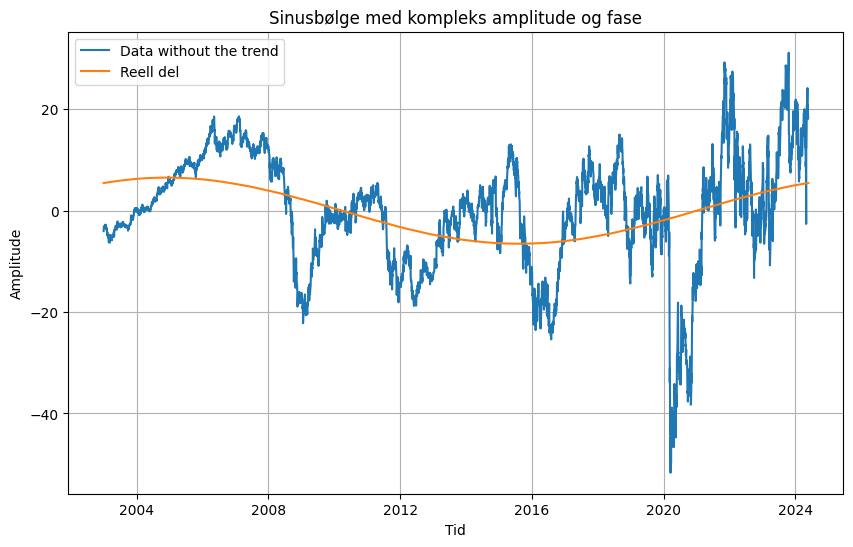

In [23]:
sinwave = create_sin(data_without_dc, n, complex_func, peak_freq)
# Plott sinusbølgen
plt.figure(figsize=(10, 6))
plt.plot(df.index, data_without_dc, label='Data without the trend')
# plt.axvline(x=period, color='red', linestyle='--', label='Period')
plt.plot(df.index, sinwave.real, label='Reell del')
# plt.plot(n, sinwave.imag, label='Imaginær del')

plt.xlabel('Tid')
plt.ylabel('Amplitude')
plt.title('Sinusbølge med kompleks amplitude og fase')
plt.legend()
plt.grid(True)
plt.show()


## Sinustilpasning med minste kvadratsmetode

Perioden mellom topper: 5405.0


c:\Users\bugat\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


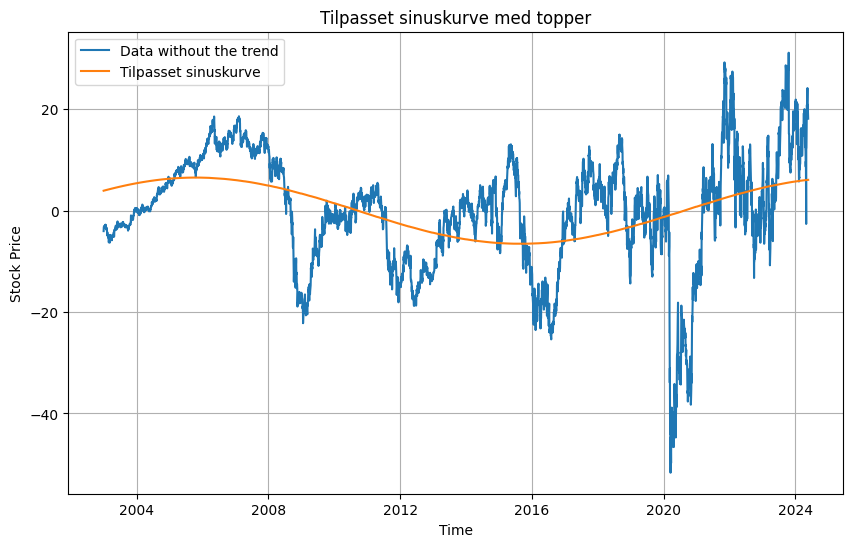

In [24]:
fitted_sin, fit= fit_sin(n, data_without_dc, complex_func, period)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df.index, data_without_dc, label='Data without the trend')

plt.plot(df.index, fitted_sin, label='Tilpasset sinuskurve')
# plt.scatter(peaks_x, peaks_y, color='red', label='Topper')
# plt.scatter(peaks_x_f, peaks_y_f, color='red', label='Topper')

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.title('Tilpasset sinuskurve med topper')
plt.show()

## Prediksjon

c:\Users\bugat\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\bugat\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


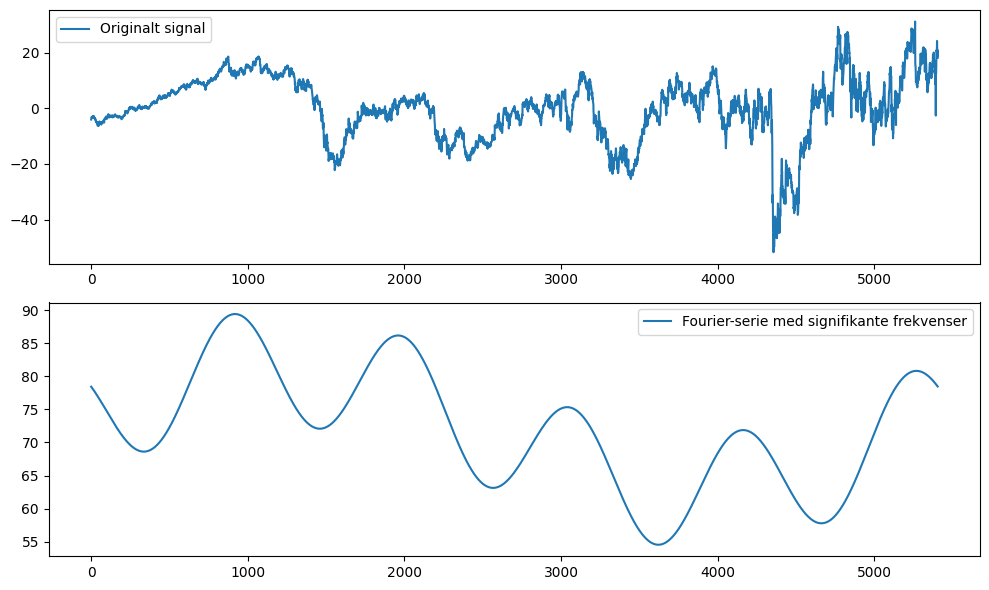

In [25]:
fourier_series = create_fourier_series(data, X_oneside, f_oneside, 2)

# Plot det opprinnelige signalet og Fourier-serien
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(data_without_dc, label='Originalt signal')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(fourier_series, label='Fourier-serie med signifikante frekvenser')
plt.legend()

plt.tight_layout()
plt.show()

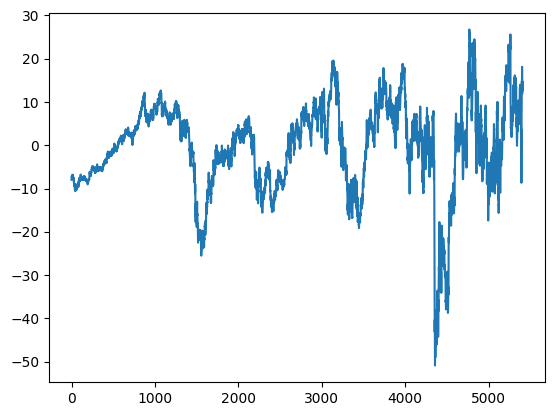

In [26]:
deseasoned = detrend - fitted_sin

plt.plot(deseasoned)